In [31]:
using Revise
using BilevelTrajOpt

using ForwardDiff
using DiffResults
using RigidBodyDynamics
using MeshCatMechanisms
using Plots
using Interpolations

In [32]:
urdf = joinpath("..", "urdf", "panda", "panda_arm.urdf")
mechanism = parse_urdf(Float64, urdf)
env = parse_contacts(mechanism, urdf, [])
x0 = MechanismState(mechanism);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
# open(mvis)
# widget = manipulate!(mvis)
IJuliaCell(mvis)

In [33]:
# simple trajopt without the box to get a trajectory to simulate

Δt = 0.02
N = 50
traj_data = get_traj_data(mechanism,env,Δt,N,false)

x_start = zeros(traj_data.num_q+traj_data.num_v)
x_goal = zeros(traj_data.num_q+traj_data.num_v)

x_start[2] = .3
x_start[4] = -2.75
x_start[6] = -1.65

x_goal[2] = .8
x_goal[4] = -1.67
x_goal[6] = -2.2

add_state_eq!(traj_data, xi -> xi - x_start, 1)
add_state_eq!(traj_data, xi -> xi - x_goal, N)
add_fn_ineq!(traj_data, xi -> -pi - xi[4], Int(N/2))

traj = BilevelTrajOpt.trajopt_snopt(traj_data)

traj_t = vcat(0.,cumsum([Δt for i in 1:N-1]));
traj_q = [traj[1:num_positions(mechanism),i] for i in 1:N]
traj_u = traj[traj_data.num_q+traj_data.num_v+1:traj_data.num_q+2*traj_data.num_v,:]
ctrl_itp = Vector()
for i = 1:traj_data.num_v
   push!(ctrl_itp, Interpolations.CubicSplineInterpolation(0.:Δt:(N-1)*Δt,traj_u[i,:],extrapolation_bc=0.))
end
traj_itp = Vector()
for i = 1:traj_data.num_q+traj_data.num_v
    push!(traj_itp, Interpolations.CubicSplineInterpolation(0.:Δt:(N-1)*Δt,traj[i,:],extrapolation_bc=traj[i,end]))
end

┌ Warning: `a::Number + b::AbstractArray` is deprecated, use `a .+ b` instead.
│   caller = +(::Int64, ::Int64, ::UnitRange{Int64}) at operators.jl:502
└ @ Base ./operators.jl:502


Finished successfully: optimality conditions satisfied


In [ ]:
setanimation!(mvis, traj_t, traj_q)

In [ ]:
# package the resulting controller in a ctrl function to test (optional)
# urdf = joinpath("..", "urdf", "panda", "panda_arm.urdf")
# mechanism = parse_urdf(Float64, urdf)

Δt = 0.02
N = 100
sim_data = get_sim_data(mechanism,env,Δt,false)

function feedforward_ctrl!(u,t,x)
    u[:] = map(ctrl_itp) do itp
       itp(t) 
    end
end
function feedback_ctrl!(u,t,x)
    Kp = 250.
    Kd = 5.
    q = configuration(x)
    v = velocity(x)
    for i = 1:length(u)
       u[i] = ctrl_itp[i](t) + Kd*(traj_itp[traj_data.num_q+i](t)-v[i]) + Kp*(traj_itp[i](t)-q[i]) 
    end
end

set_configuration!(x0,x_start[1:traj_data.num_q])
set_velocity!(x0,x_start[sim_data.num_q+1:sim_data.num_q+sim_data.num_v])
setdirty!(x0)

traj_sim = BilevelTrajOpt.simulate_snopt(sim_data,feedback_ctrl!,x0,N-1)
traj_t_sim = vcat(0.,cumsum([Δt for i in 1:N-1]));
traj_q_sim = [traj_sim[1:num_positions(mechanism),i] for i in 1:N];

In [ ]:
setanimation!(mvis, traj_t_sim, traj_q_sim)

In [192]:
# simulating the panda arm pushing the box with the controller

urdf = joinpath("..", "urdf", "panda", "panda_arm_box.urdf")
mechanism = parse_urdf(Float64, urdf)

box_body = findbody(mechanism, "box")
basejoint = joint_to_parent(box_body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)

# adding surfaces
# Floor
μ = .42
motion_type = :xyz
floor_body = findbody(mechanism, "floor")
point = Point3D(default_frame(floor_body), [0.,0.,0.])
normal = FreeVector3D(default_frame(floor_body), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type, floor_body)

# Box (right now torque on the plane is ignored)
μ = 0.05
motion_type = :xyz
box_body = findbody(mechanism, "box")
point = Point3D(default_frame(box_body), [-.25,0.,.25])
normal = FreeVector3D(default_frame(box_body), [-1.,0.,0.])
hs = HalfSpace(point, normal)
box = Obstacle(hs, μ, motion_type, box_body, is_floating=true)

# obstacles = [floor]
obstacles = [floor,box]

env = parse_contacts(mechanism, urdf, obstacles)
Δt = 0.02
x0 = MechanismState(mechanism)
sim_data = get_sim_data(mechanism,env,Δt,false)

function feedback_ctrl_with_box!(u,t,x)
    u[:] .= 0.
    
    Kp = 250.
    Kd = 5.
    
    # todo use naming of states instead of assuming order
    q = configuration(x)[8:end]
    v = velocity(x)[7:end]
    for i = 1:length(u[7:end])
       u[6+i] = ctrl_itp[i](t) + Kd*(traj_itp[7+i](t)-v[i]) + Kp*(traj_itp[i](t)-q[i]) 
    end
end

feedback_ctrl_with_box! (generic function with 1 method)

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)
# IJuliaCell(mvis)

In [36]:
N = 100

x_start = zeros(sim_data.num_q+sim_data.num_v)

# box
x_start[1] = 1.
x_start[5] = .8
x_start[7] = .275

# arm
x_start[7+2] = .3
x_start[7+4] = -2.75
x_start[7+6] = -1.65

set_configuration!(x0,x_start[1:sim_data.num_q])
set_velocity!(x0,x_start[sim_data.num_q+1:sim_data.num_q+sim_data.num_v])
setdirty!(x0)

sim_traj = BilevelTrajOpt.simulate_snopt(sim_data,feedback_ctrl_with_box!,x0,N-1)
sim_traj_t = vcat(0.,cumsum([Δt for i in 1:N-1]));
sim_traj_q = [sim_traj[1:num_positions(mechanism),i] for i in 1:N];
sim_traj_u = zeros(sim_data.num_v,N)
for i=1:N
    set_configuration!(x0,sim_traj[1:sim_data.num_q,i])
    set_velocity!(x0,sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i])
    setdirty!(x0)
    t = sim_traj_t[i]
    u = zeros(sim_data.num_v)
    feedback_ctrl_with_box!(u,t,x0)
    sim_traj_u[:,i] = u[:]
end

Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished s

In [ ]:
setanimation!(mvis, sim_traj_t, sim_traj_q)

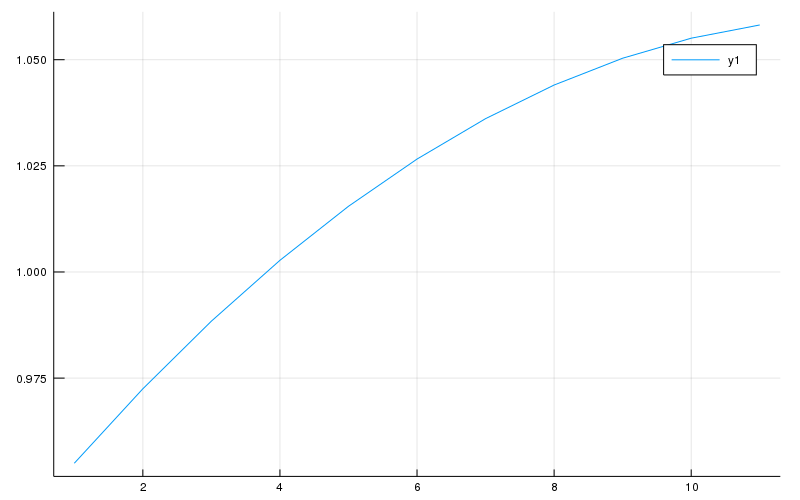

In [272]:
gr(size=(800,500), html_output_format=:png);
plot(sim_traj[5,50:60])

In [273]:
# regressing the parameters of that simulation back (friction and inertia of box)

# portion of the traj we will use for parameter regression
regression_indx_raw = collect(50:60)

# pre-computing some of the transforms needed for the regression
regression_indx = []
contact_params = []
for i = 1:length(regression_indx_raw)
    q0 = sim_traj[1:sim_data.num_q,regression_indx_raw[i]]
    v0 = sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,regression_indx_raw[i]]
    u0 = sim_traj_u[:,regression_indx_raw[i]]
    qnext = sim_traj[1:sim_data.num_q,regression_indx_raw[i]+1]
    vnext = sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,regression_indx_raw[i]+1]
    cp = compute_contact_params(sim_data,q0,v0,u0,qnext,vnext)
    # only use datapoints where the contact points were active
    if all(cp.ϕs[1:4] .< 1e-6)
        push!(regression_indx, regression_indx_raw[i])
        push!(contact_params, cp)
    end
end
l_contact_params = length(contact_params)

function friction_loss(μs)
    sim_data.μs[1:5] .= μs[1]
    
    loss = 0.
    for i = 1:length(contact_params)
        cp = contact_params[i]
        x, λ, μ = solve_implicit_contact_τ(sim_data,cp.ϕs,cp.Dtv,
                                           cp.rel_transforms,cp.geo_jacobians,cp.geo_jacobians_surfaces,
                                           cp.HΔv,cp.bias,cp.contact_x0,cp.contact_λ0,cp.contact_μ0,
                                           ip_method=false,in_place=false,comp_scale=1000.,num_fosteps=1,num_sosteps=3)
        d = dynamics_contact_constraints(x,cp.rel_transforms,cp.geo_jacobians,cp.geo_jacobians_surfaces,
                                         cp.HΔv,cp.bias,sim_data)
        loss += (d[1:6]'*d[1:6])/l_contact_params
    end
    
    loss
end

fric_res = DiffResults.GradientResult(zeros(1))
function friction_fn(μs)
    @time ForwardDiff.gradient!(fric_res, friction_loss, μs)
    J = DiffResults.value(fric_res)
    gJ = DiffResults.gradient(fric_res)
    c = []
    gc = []
    fail = false
    J, c, gJ, gc, fail
end

μs0 = [1.]
lb = zeros(length(μs0))
ub = ones(length(μs0))
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

μsopt, fopt, info = snopt(friction_fn, μs0, lb, ub, options)

display(info)
display(μsopt)

┌ Warning: Deprecated syntax `implicit assignment to global variable `i``.
│ Use `global i` instead.
└ @ nothing none:0
┌ Warning: Loop variable `i` around In[273]:9 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[273]:9


 10.220975 seconds (89.25 M allocations: 4.727 GiB, 40.87% gc time)
 10.119523 seconds (89.13 M allocations: 4.721 GiB, 41.14% gc time)
 10.380442 seconds (89.13 M allocations: 4.721 GiB, 40.77% gc time)
 10.206138 seconds (89.13 M allocations: 4.721 GiB, 41.00% gc time)
 10.132035 seconds (89.13 M allocations: 4.721 GiB, 40.92% gc time)
 10.142115 seconds (89.13 M allocations: 4.721 GiB, 40.91% gc time)
 10.251191 seconds (89.13 M allocations: 4.721 GiB, 41.05% gc time)
 10.366533 seconds (89.13 M allocations: 4.721 GiB, 40.79% gc time)
 10.336379 seconds (89.13 M allocations: 4.721 GiB, 40.75% gc time)
 10.019575 seconds (89.13 M allocations: 4.721 GiB, 41.32% gc time)
 10.100869 seconds (89.13 M allocations: 4.721 GiB, 41.16% gc time)
 10.127992 seconds (89.13 M allocations: 4.721 GiB, 41.01% gc time)
 10.287049 seconds (89.13 M allocations: 4.721 GiB, 40.59% gc time)


"Finished successfully: optimality conditions satisfied"

1-element Array{Float64,1}:
 0.4200163309680407

 10.022016 seconds (89.13 M allocations: 4.721 GiB, 41.26% gc time)


In [29]:
# regressing a simple ball simulation with one point of contact (toy example to debug)

urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
μ = 0.34
motion_type = :xyz 
floor_body = findbody(mechanism, "floor")
point = Point3D(default_frame(floor_body), [0.,0.,0.])
normal = FreeVector3D(default_frame(floor_body), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type, floor_body)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005
sim_data = get_sim_data(mechanism,env,Δt,false);

N = 100
q0 = [1., 0., 0., 0., 0., 0., 0.]
v0 = [0., 0., 0., 5., 0., 0.]

u0 = zeros(sim_data.num_v)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
ctrl! = (u,t,x) -> u[:] .= 0.
traj = BilevelTrajOpt.simulate_snopt(sim_data,ctrl!,x0,N);

Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished s

In [30]:
function friction_loss(μs)
    sim_data.μs[:] = μs[:]
    
    loss = 0.
    for i = 1:N-1
        q0 = traj[1:sim_data.num_q,i]
        v0 = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i]
        qnext = traj[1:sim_data.num_q,i+1]
        vnext = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i+1]
        τ, x, d = solve_implicit_contact_τ(sim_data,q0,v0,u0,qnext,vnext,ip_method=false,in_place=true) 
        loss += d'*d 
    end
    
    loss
end

fric_res = DiffResults.GradientResult(zeros(sim_data.num_contacts))
function friction_fn(μs)
    ForwardDiff.gradient!(fric_res, friction_loss, μs)
    J = DiffResults.value(fric_res)
    gJ = DiffResults.gradient(fric_res)
    
    c = []
    gc = []
    
    fail = false
    
    J, c, gJ, gc, fail
end

μs0 = [1.]
lb = zeros(length(μs0))
ub = ones(length(μs0))
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

μsopt, fopt, info = snopt(friction_fn, μs0, lb, ub, options)

display(info)
display(μsopt)

"Finished successfully: optimality conditions satisfied"

1-element Array{Float64,1}:
 0.3400092295042869